In [1]:
!git config --global core.askpass /usr/libexec/git-core/git-gui--askpass

In [2]:
!git clone https://cmejia99@bitbucket.org/cmejia99/proyecto-lenguaje-de-senas.git

fatal: destination path 'proyecto-lenguaje-de-senas' already exists and is not an empty directory.


In [3]:
!pip install comet_ml

In [4]:
from comet_ml import Experiment

In [5]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="yDx9qlAQYPtxMnLfZIisUuqkf",
    project_name="Lenguaje de senas",
    workspace="cmejia99",
    log_code=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/cmejia99/lenguaje-de-senas/6b9553c8de22413fab60c0a5c3a16d73



In [6]:
from Modelos import models
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import time

In [7]:
###Clase que tiene el proposito de cargar los datos del data set.
class dataSet:
    def __init__(self,width,height,batch_size):
        self.dir_base='DataSet/'       
        self.width = width
        self.height = height
        self.batch_size = batch_size
        self.train_ts = None
        self.test_ts = None
        self.train_ts, self.test_ts = self.Load_dataSet()        
    def Load_dataSet(self):
        train_dt = image_dataset_from_directory(directory=self.dir_base, ##Directorio de la imagenes.
                                                labels='inferred', ##Etiquetas apartir del directorio.
                                                label_mode='categorical', ##Modo categorico.
                                                batch_size=self.batch_size, ##Tamaño de lotes.
                                                image_size=(self.width, self.height), ##Escala a este tamaño las imagenes.
                                                seed = 1,
                                                validation_split = 0.2, ##Porcentaje del tamaño del data set.
                                                subset = "training" ##Definición del tipo de data set que es, en este caso validación.
                                                )        
        test_dt = image_dataset_from_directory(directory=self.dir_base, ##Directorio de la imagenes.
                                                labels='inferred', ##Etiquetas apartir del directorio.
                                                label_mode='categorical', ##Modo categorico.
                                                batch_size=self.batch_size, ##Tamaño de lotes.
                                                image_size=(self.width, self.height), ##Escala a este tamaño las imagenes.
                                                seed = 1,
                                                validation_split = 0.2, ##Porcentaje del tamaño del data set.
                                                subset = "validation" ##Definición del tipo de data set que es, en este caso validación.
                                                )     
        return train_dt, test_dt
    def Normalization(self,data_set):
        nor_ly = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) 
        new_ds = data_set.map(lambda x, y: (nor_ly(x), y)) 
        ###Visualizamos los pixeles maximos y minimos del data set:
        image_batch1, labels_batch1 = next(iter(data_set))
        first_image1 = image_batch1[0]
        image_batch, labels_batch = next(iter(new_ds))
        first_image = image_batch[0]
        #Se saca el valor del pixel maximo y minimo:
        print('Imagen Original', np.min(first_image1), np.max(first_image1))
        print('Imagen Escalada',np.min(first_image), np.max(first_image))
        return new_ds
    ###Funcion que devuelve los datos en objeto lista
    def generated_vector(self,ds,x_ds,y_ds):     
        iterador = iter(ds)  
        while True:
            try:          
                batch = next(iterador)
                iterador2 = iter(batch)    
                images = next(iterador2)
                labels = next(iterador2)        
                it_img = iter(images)    
                it_lab = iter(labels)    
                while True:    
                    try:
                        image = next(it_img)    
                        label = next(it_lab)
                        x_ds.append(image.numpy())
                        y_ds.append(label.numpy())
                    except StopIteration:
                        break                        
            except StopIteration:
                break          
        return x_ds,y_ds  
    ##Función que retorna las entradas en tipo numpy    
    def list_to_numpy(self,data,label):
        x_data= np.array(data)
        y_label= np.array(label)    
        return x_data,y_label 
    def generated_vector_nw(self,ds,x_ds,y_ds):
        i = 0
        iterador = iter(ds)  
        batch = next(iterador)
        x_ds = batch[0].numpy()
        y_ds = batch[1].numpy()
        while True:
            try:          
                i += 1
                batch = next(iterador)
                x_ds = np.concatenate((x_ds, batch[0].numpy()), axis=0)
                y_ds = np.concatenate((y_ds, batch[1].numpy()), axis=0)
            except StopIteration:
                break          
        return x_ds,y_ds
    def load_image_comet(self,experiment,x_ds,y_ds,labels,name):
        itera = 0
        for i in x_ds:            
            letra = np.argmax(y_ds[itera])            
            experiment.log_image(i, name=name+labels[letra], overwrite=False,image_shape=(200,200,3))            
            itera+=1

In [8]:
##Se coloca 32 como tamaño de bacth porque se satura la GPU:
Data = dataSet(200,200,32)
nombres_clases = Data.train_ts.class_names  ##Nombres de las clases
print("####Train####")
Data.train_ts = Data.Normalization(Data.train_ts)
print("####Test####")
Data.test_ts = Data.Normalization(Data.test_ts)
print(nombres_clases)

Found 73793 files belonging to 24 classes.
Using 59035 files for training.
Found 73793 files belonging to 24 classes.
Using 14758 files for validation.
####Train####
Imagen Original 0.0 255.0
Imagen Escalada 0.0 1.0
####Test####
Imagen Original 0.0 255.0
Imagen Escalada 0.0 1.0
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [ ]:
#####Se crean los vectores de entrenamiento y test######
X_train = []
Y_train = []
X_test = []
Y_test = []
inicio = time.time()
X_train,Y_train = Data.generated_vector_nw(Data.test_ts,X_train,Y_train)
X_train,Y_train = Data.list_to_numpy(X_train,Y_train)
X_test,Y_test = Data.generated_vector_nw(Data.test_ts,X_test,Y_test)
X_test,Y_test = Data.list_to_numpy(X_test,Y_test)
fin = time.time()
print((fin -inicio))

In [7]:
Data.load_image_comet(experiment,X_train,Y_train,nombres_clases,'Train/')
Data.load_image_comet(experiment,X_test,Y_test,nombres_clases,'Test/')

In [9]:
Modelos = models(Data.width,Data.height,20)
Model_CNN2 = Modelos.cnn_v2()
optimo= SGD(learning_rate=0.001, momentum =0.9)
Model_CNN2 = Modelos.Generated_model(Model_CNN2,optimo)
Model_CNN2.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928 

In [10]:
history2, loss2, acc2 = Modelos.execute_model(Model_CNN2,Data.train_ts, Data.test_ts)
print("Loss:{0} - Accuracy:{1}".format(loss2,acc2))
print('> %.3f' % (acc2*100.0))
Model_CNN2.save('Modelos//Modelo_2.h5')

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/20


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


1845/1845 [==============================] - 470s 238ms/step - loss: 2.7459 - accuracy: 0.1652 - val_loss: 2.1283 - val_accuracy: 0.3145
Epoch 2/20
1845/1845 [==============================] - 436s 236ms/step - loss: 1.4956 - accuracy: 0.4884 - val_loss: 0.7972 - val_accuracy: 0.7454
Epoch 3/20
1845/1845 [==============================] - 435s 235ms/step - loss: 0.7890 - accuracy: 0.7203 - val_loss: 0.4504 - val_accuracy: 0.8557
Epoch 4/20
1845/1845 [==============================] - 435s 235ms/step - loss: 0.5230 - accuracy: 0.8118 - val_loss: 0.2815 - val_accuracy: 0.9055
Epoch 5/20
1845/1845 [==============================] - 435s 236ms/step - loss: 0.3741 - accuracy: 0.8660 - val_loss: 0.1856 - val_accuracy: 0.9373
Epoch 6/20
1845/1845 [==============================] - 436s 236ms/step - loss: 0.2889 - accuracy: 0.8965 - val_loss: 0.1902 - val_accuracy: 0.9325
Epoch 7/20
1845/1845 [==============================] - 436s 236ms/step - loss: 0.2243 - accuracy: 0.9194 - val_loss: 0.128

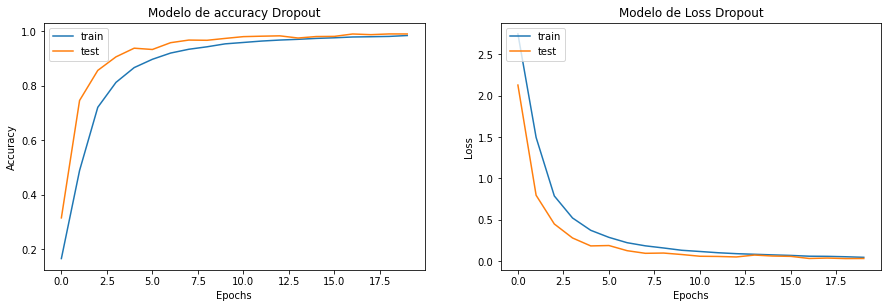

In [11]:
Modelos.graphics(history2,'Dropout')

In [12]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/cmejia99/lenguaje-de-senas/6b9553c8de22413fab60c0a5c3a16d73
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [20]                 : (0.16520708799362183, 0.9837554097175598)
COMET INFO:     batch_accuracy [3700]         : (0.03125, 1.0)
COMET INFO:     batch_loss [3700]             : (0.005496357101947069, 3.178022623062134)
COMET INFO:     epoch_duration [20]           : (433.3396552100003, 470.4659011150002)
COMET INFO:     loss [20]                     : (0.04773692414164543, 2.7459487915039062)
COMET INFO:     val_accuracy [20]             : (0.3145412802696228, 0.9895649552345276)
COMET INFO:     val_loss [20]                 : (0.03273048624396324, 2.128325939178467)
COMET INFO:     validate_batch_accuracy [940] : (0.310036